
02_model_training.ipynb : Modélisation et Tracking MLflow

 **Objectif :** Entraîner une baseline et un modèle avancé, en gérant le déséquilibre des classes et en traquant les performances (notamment le coût métier) via MLflow.



In [14]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import mlflow
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from mlflow.models.signature import infer_signature
import sys
import os
import lightgbm as lgb

# Ajout du chemin src pour importer nos modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

from model_utils import (
    prepare_data_for_training, 
    train_cv_and_log, 
    plot_business_cost_threshold,
    optimize_hyperparameters_optuna,
    export_model_to_folder
)

from metrics import custom_business_cost

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# Configuration MLflow
EXPERIMENT_NAME = "Credit_Scoring_Final"
mlflow.set_tracking_uri("file:../mlruns")

# ## 1. Chargement et Préparation des Données
# La fonction `prepare_data_for_training` charge les CSV, **nettoie les noms de colonnes** (pour éviter l'erreur JSON LightGBM), gère les infinis, et effectue le split stratifié.
PATH_TRAIN = '../datasets/final/train_enriched.csv'
PATH_LABELS = '../datasets/final/train_labels.csv'

# X_train et X_val sont déjà nettoyés ici !
X_train, X_val, y_train, y_val = prepare_data_for_training(PATH_TRAIN, PATH_LABELS)

print(f"Données chargées. Train shape: {X_train.shape}")

Chargement des données...
Nettoyage des noms de colonnes...
Split Train/Validation (Stratifié)...
Données chargées. Train shape: (246008, 1845)


In [16]:
X_train.shape

(246008, 1845)

In [ ]:
# ## 2. Étape 3 : Validation Croisée (Baseline vs LightGBM)
# Nous comparons la robustesse des modèles sur 5 plis (folds).
# --- MODELE 1 : BASELINE (Régression Logistique) ---
# Pipeline nécessaire pour gérer les NaN
pipe_lr = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(C=1.0, class_weight='balanced', max_iter=500))
])

print("\n--- Cross-Validation: Baseline ---")
# On utilise X_train pour la CV (le set de validation final X_val est gardé pour l'optimisation du seuil)
model_lr_cv, cost_lr = train_cv_and_log(
    pipe_lr, X_train, y_train, EXPERIMENT_NAME, "CV_Baseline_LogReg"
)

In [5]:
# --- MODELE 2 : LightGBM (Avancé) ---
# LightGBM gère les NaN nativement
lgbm = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    class_weight='balanced',
    n_jobs=3,
    random_state=42,
    verbose=-1
)

print("\n--- Cross-Validation: LightGBM ---")

model_lgbm_cv, cost_lgbm = train_cv_and_log(
    lgbm, X_train, y_train, EXPERIMENT_NAME, "CV_LightGBM_Default"
)



--- Cross-Validation: LightGBM ---
--- Cross-Validation (5 folds) : CV_LightGBM_Default ---
  >> Moyenne CV: Coût=24323.2 | AUC=0.784


2025/12/07 15:29:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


In [6]:
# 1. Échantillonnage (20% pour aller vite et éviter saturation RAM)
X_sample = X_train.sample(frac=0.2, random_state=42)
y_sample = y_train[X_sample.index]

print("Lancement de l'optimisation Optuna...")

# 2. Recherche des meilleurs hyperparamètres
best_params = optimize_hyperparameters_optuna(
    X_sample, 
    y_sample, 
    experiment_name=EXPERIMENT_NAME, 
    n_trials=50
)

[I 2025-12-07 15:29:40,161] A new study created in memory with name: no-name-0984d1ce-0dd0-493d-95b1-634fc30e69ef


Lancement de l'optimisation Optuna...
--- Optimisation Optuna (50 essais) ---


[I 2025-12-07 15:30:33,036] Trial 0 finished with value: 0.7357586655918839 and parameters: {'n_estimators': 580, 'learning_rate': 0.052557959396110875, 'num_leaves': 48, 'max_depth': 6, 'reg_alpha': 0.0005648385656395725, 'reg_lambda': 0.00027029127162122755, 'colsample_bytree': 0.6861454667113107, 'subsample': 0.6329341775873134}. Best is trial 0 with value: 0.7357586655918839.
[I 2025-12-07 15:32:06,235] Trial 1 finished with value: 0.7480593510468795 and parameters: {'n_estimators': 983, 'learning_rate': 0.0323822303189231, 'num_leaves': 29, 'max_depth': 14, 'reg_alpha': 0.21997580532281788, 'reg_lambda': 1.429495007557994, 'colsample_bytree': 0.7701657757114534, 'subsample': 0.7808728360469694}. Best is trial 1 with value: 0.7480593510468795.
[I 2025-12-07 15:33:27,113] Trial 2 finished with value: 0.751418973462395 and parameters: {'n_estimators': 770, 'learning_rate': 0.021182485251281427, 'num_leaves': 49, 'max_depth': 14, 'reg_alpha': 2.8183570055886457e-06, 'reg_lambda': 5.07

Meilleurs params: {'n_estimators': 675, 'learning_rate': 0.015575585783848033, 'num_leaves': 20, 'max_depth': 11, 'reg_alpha': 0.002462326766172488, 'reg_lambda': 0.006221181256904489, 'colsample_bytree': 0.6244161373629653, 'subsample': 0.5475831202283172}


In [4]:
# 1. On définit MANUELLEMENT les meilleurs paramètres trouvés précédemment (Trial 4)
print("Utilisation des paramètres manuels ...")
#meilleurs paramètres trouvés jusqu'à présent
fixed_params = {
    'n_estimators': 536,
    'learning_rate': 0.0146,       # Apprentissage lent et précis
    'num_leaves': 53,
    'max_depth': 11,
    'reg_alpha': 6.132,            # Forte régularisation L1 (Nettoie le bruit)
    'reg_lambda': 1.45e-07,        # Régularisation L2 faible
    'colsample_bytree': 0.915,
    'subsample': 0.977
}

Utilisation des paramètres manuels ...


In [7]:
# 3. Entraînement du modèle final avec les paramètres gagnants
print("\nEntraînement du modèle final...")
best_lgbm = LGBMClassifier(
    **fixed_params,          # On injecte les paramètres trouvés par Optuna
    class_weight='balanced',
    n_jobs=-1,              # Utilise tous les cœurs
    random_state=42,
    verbose=1
)

# 4. Optimisation du seuil métier (Sur le set de validation complet)
best_lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=200)]
)
print("\n--- Évaluation du Modèle ---")
y_val_proba = best_lgbm.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(y_val, y_val_proba)
print(f"ROC AUC Score : {auc_score:.4f}")


Entraînement du modèle final...
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.747867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 211504
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 1837
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.772813	valid_0's binary_logloss: 0.563864
[400]	valid_0's auc: 0.784684	valid_0's binary_logloss: 0.534357
Did not meet early stopping. Best iteration is:
[536]	valid_0's auc: 0.787471	valid_0's binary_logloss: 0.521881

--- Évaluation du Modèle ---
ROC AUC Score : 0.7875


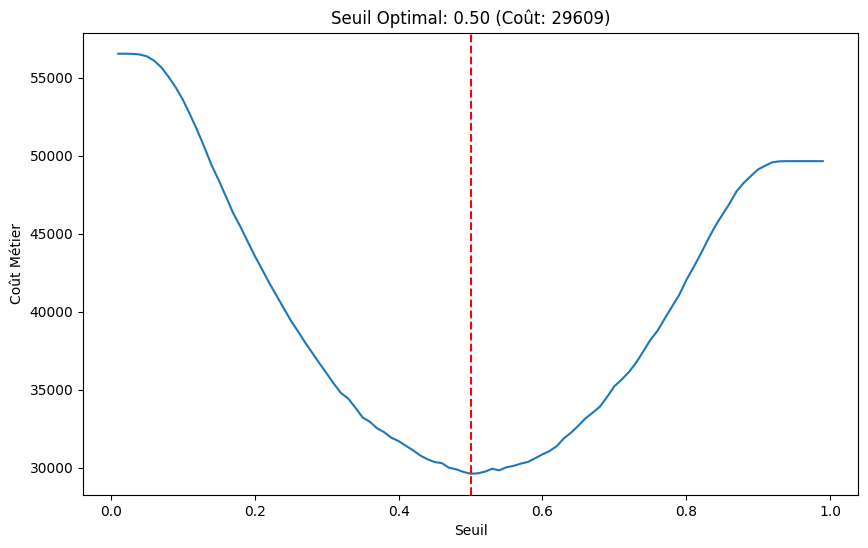


>>> MODÈLE FINAL OPTIMISÉ <<<
Seuil de décision : 0.500


c:\Users\mathi\OneDrive\Bureau\ESAIP\ING4\MAJEUR\Majeur_IA310\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/12/11 19:53:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✅ Modèle loggé dans MLflow avec run_id: b92fdee0c0564154bda86391dde6dc01
   Utilisez export_model_to_folder(run_id='b92fdee0c0564154bda86391dde6dc01') pour exporter vers model/


In [10]:
fig, best_thresh = plot_business_cost_threshold(y_val, y_val_proba)
plt.show()

print(f"\n>>> MODÈLE FINAL OPTIMISÉ <<<")
print(f"Seuil de décision : {best_thresh:.3f}")

# Sauvegarde finale dans MLflow (pas directement dans model/)
# On utilisera export_model_to_folder() après pour exporter vers model/
with mlflow.start_run(run_name="Final_Model_Optuna"):
    # Logging des paramètres
    mlflow.log_params(fixed_params)
    mlflow.log_param("optimal_threshold", best_thresh)
    
    # Logging des métriques
    y_pred_optimal = (y_val_proba >= best_thresh).astype(int)
    from metrics import get_metrics
    metrics = get_metrics(y_val, y_pred_optimal, y_val_proba)
    mlflow.log_metrics(metrics)
    
    # Logging de la figure
    mlflow.log_figure(fig, "business_cost_curve.png")
    
    # Logging du modèle dans MLflow (pas sur disque local)
    signature = infer_signature(X_train, best_lgbm.predict(X_train))
    mlflow.sklearn.log_model(
        best_lgbm, 
        "model",  # Nom de l'artefact dans MLflow (pas un chemin local)
        signature=signature,
        input_example=X_train.iloc[:5]
    )
    
    # Sauvegarder le run_id pour l'export ultérieur
    final_run_id = mlflow.active_run().info.run_id
    print(f"\n✅ Modèle loggé dans MLflow avec run_id: {final_run_id}")
    print(f"   Utilisez export_model_to_folder(run_id='{final_run_id}') pour exporter vers model/")

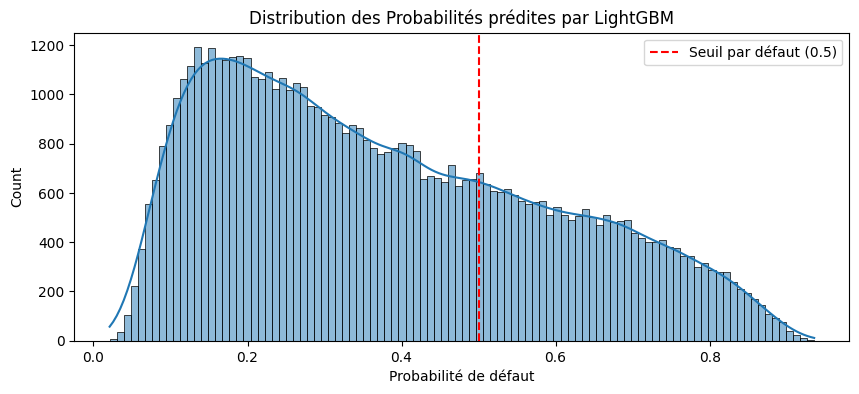

Probabilité Min: 0.0210
Probabilité Moyenne: 0.3795
Probabilité Max: 0.9357

--- RÉSULTAT CORRIGÉ ---
Seuil Optimal Réel : 0.515
Coût Minimum : 29577
Coût avec seuil 0.50 : 29609
Économie réalisée : 32 points

--- Performance au Seuil Optimal ---
              precision    recall  f1-score   support

           0       0.96      0.76      0.85     56538
           1       0.20      0.68      0.31      4965

    accuracy                           0.75     61503
   macro avg       0.58      0.72      0.58     61503
weighted avg       0.90      0.75      0.81     61503



In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Récupérer les probas du modèle final (déjà entraîné)
y_val_proba = best_lgbm.predict_proba(X_val)[:, 1]

# 2. DIAGNOSTIC : L'Histogramme des probabilités
# C'est LE graphique le plus important pour comprendre votre modèle
plt.figure(figsize=(10, 4))
sns.histplot(y_val_proba, bins=100, kde=True)
plt.axvline(0.5, color='r', linestyle='--', label="Seuil par défaut (0.5)")
plt.title("Distribution des Probabilités prédites par LightGBM")
plt.xlabel("Probabilité de défaut")
plt.legend()
plt.show()

print(f"Probabilité Min: {y_val_proba.min():.4f}")
print(f"Probabilité Moyenne: {y_val_proba.mean():.4f}")
print(f"Probabilité Max: {y_val_proba.max():.4f}")

# 3. Recherche Granulaire du Seuil
# On cherche très précisément entre 0.01 et 0.50 (la zone critique)
thresholds = np.arange(0.01, 0.95, 0.005) 
costs = []

for thresh in thresholds:
    y_pred_t = (y_val_proba >= thresh).astype(int)
    cost = custom_business_cost(y_val, y_pred_t) # Assurez-vous que y_val est bien le bon format (Series ou array)
    costs.append(cost)

# Trouver le min
min_cost_index = np.argmin(costs)
real_best_thresh = thresholds[min_cost_index]
min_cost_val = costs[min_cost_index]

print(f"\n--- RÉSULTAT CORRIGÉ ---")
print(f"Seuil Optimal Réel : {real_best_thresh:.3f}")
print(f"Coût Minimum : {min_cost_val}")

# 4. Vérification d'impact
# Comparons le coût à 0.5 vs le coût au seuil optimal
y_pred_05 = (y_val_proba >= 0.5).astype(int)
cost_05 = custom_business_cost(y_val, y_pred_05)

print(f"Coût avec seuil 0.50 : {cost_05}")
print(f"Économie réalisée : {cost_05 - min_cost_val} points")

# 5. Rapport de classification final
y_pred_final = (y_val_proba >= real_best_thresh).astype(int)
print("\n--- Performance au Seuil Optimal ---")
print(classification_report(y_val, y_pred_final))

## Export du Modèle pour Docker

Une fois le modèle final entraîné et loggé dans MLflow, vous pouvez l'exporter vers le dossier `model/` pour le Dockerfile.

**Option 1 : Exporter depuis un run_id spécifique**
```python
# Récupérer le run_id depuis MLflow UI ou depuis la variable active_run
run_id = mlflow.active_run().info.run_id  # Si vous êtes dans un run actif
# OU utiliser un run_id connu
export_model_to_folder(run_id="af5897f2130b491a9c3ce5320561668f")
```

**Option 2 : Exporter depuis le registry MLflow**
```python
export_model_to_folder(
    model_name="model",
    experiment_name="Credit_Scoring_Final"
)
```



In [13]:
# Exemple : Exporter le modèle final vers le dossier model/
# Remplacez "VOTRE_RUN_ID" par le run_id du modèle que vous voulez exporter
# Vous pouvez le trouver dans MLflow UI ou utiliser mlflow.active_run().info.run_id

# Option 1 : Si vous connaissez le run_id
export_model_to_folder(run_id="b92fdee0c0564154bda86391dde6dc01")

# Option 2 : Exporter depuis le registry (recommandé)
"""export_model_to_folder(
    model_name="model",
    experiment_name=EXPERIMENT_NAME,
    tracking_uri="file:../mlruns"
)"""

print("\n✅ Le modèle est maintenant prêt pour Docker !")
print("   Vous pouvez construire l'image avec: docker build -t credit-scoring-model .")



Export depuis run_id: b92fdee0c0564154bda86391dde6dc01
Téléchargement du modèle depuis MLflow...


Copie des fichiers vers ../model/...
  ✓ MLmodel
  ✓ model.pkl
  ✓ conda.yaml
  ✓ requirements.txt
  ✓ python_env.yaml

✅ Modèle exporté avec succès vers ../model/
   Vous pouvez maintenant construire l'image Docker avec: docker build -t credit-scoring-model .

✅ Le modèle est maintenant prêt pour Docker !
   Vous pouvez construire l'image avec: docker build -t credit-scoring-model .
